<a href="https://colab.research.google.com/github/alexfok/IntroDeepLearning2022/blob/main/IDL_Project_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alexander Fok 308669944

Avi Dvir 204423735

Gal Cohen 204675805

# Project: Unsupervised Deep Embedding for Clustering Analysis - Part#1 - Data Exploration and Models Training

**Project Supervisor**: May Malka.

In this project, we build a Unsupervised Deep Embedding for Clustering Analysis with AE, etc 


# **Section 1: Environment Initialization**

## Imports


In [25]:
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torchvision.utils import make_grid
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import os
import zipfile


%pip install wget   
import wget

# Imports for MNIST loading
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import datasets, transforms

# Imports for STL10 loading
import sys
import os, sys, tarfile, errno
import random


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Control Variables and Initialization

In [26]:
# Notebook Control variables
DEBUG_STL10 = False
# Print DEBUG info
DEBUG = False
# Variable controlling debug prints while training\infering with NN
DEBUG_NN = False
# Create the data sets or load the preloaded np arrays
CREATE_DATA = True
# Path to save the created numpy arrays
array_save_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/data.npy'
# Path to load the created numpy arrays
array_load_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/data.npy.npz'
#best_model_path = '/content/gdrive/MyDrive/IntroDeepLearning2022Data/project/model_chkpt_epoch_20.pk'
#checkpoint_path = '/content/gdrive/MyDrive/IntroDeepLearning2022Data/project/model_chkpt_epoch_{}.pk'
#model_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project_model2.pk'
model_path_stl10 = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/project_model2_stl10.pk'
model_path_mnist = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/project_model2_mnist.pk'
# Raw data set paths
path_train = "/content/gdrive/My Drive/IntroDeepLearning2022Data/project"
#path_train = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/train/*.*"
#path_test_m = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/test_m/*.*"
#path_test_w = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/test_w/*.*"
# Set random seeds

# use GPU for computation if possible: Go to RUNTIME -> CHANGE RUNTIME TYPE -> GPU
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CPU\GPI device: {dev}')

torch.manual_seed(1)
torch.cuda.manual_seed(1)

CPU\GPI device: {dev}


Connect to your Google Drive, select the path in your drive for saving the checkpoints of your model, which we will train later.

## Helper Functions


In [27]:
# Function to count number of model parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

# Function to display images
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(15, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N], cmap='Greys_r')
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(15, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N], cmap='Greys_r')
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

# Section 2: Data Load
## Data Statistics

In this assignement we are using the CelebFaces Attributes Dataset (CelebA).

The CelebA dataset, as its name suggests, is comprised of celebrity faces. The images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong.

**Overall**

- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

In this torchvision version of the dataset, each image is in the shape of
$[218,178,3]$ and the values are in $[0,1]$.

MNIST Data
- number of images in training set: 60000
- number of images in test set: 10000
- image shape: $(28, 28)$.
- 10 image classes: ``0,1,2,3,4,5,6,7,8,9``
- We resize the images to $(32, 32)$, to allow the usage of the same NN architecture, that assumes image shapes of $(H/2^4, W/2^4)$.

STL10 Data
- stl10_binary.tar.gz size: 2.5 gb
- number of images in training set: 5000
- number of images in test set: 8000
- image shape: $(96, 96, 3)$.
- 10 image classes: 
 `` airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck``
- Due to lack of RAM, we didn't use unlabeled images dataset - 100000 images.

## Load MNIST dataset
We direclty load the images by batches. Note that we keep the division of the data into training and test sets to get some sense on how the variational autoencoder adapts during the trainig procedure. Nonetheless, there are no lables used here as this is unsupervised learning.

In [28]:
#mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
#mnist_data = list(mnist_data)[:4096]

#batch_size = 256
 
#train_loader = torch.utils.data.DataLoader(
#    MNIST('./data', train=True, download=True,
#                   transform=transforms.ToTensor()),
#    batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(
#    MNIST('./data', train=False, transform=transforms.ToTensor()),
#    batch_size=batch_size, shuffle=True)

#mnist_data = train_loader.dataset.detach().numpy()
#mnist_data = train_loader.dataset
#mnist_data = next(iter(train_loader))[0].numpy()
def create_mnist_dataset():
    print(f'Creating MNIST dataset')
    norm_mean = 0.5 
    norm_std = 0.5 
#    image_h, image_w = (28, 28)
    image_size = (32, 32)

#    trfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((norm_mean,), (norm_std,))])
#    trfm = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), transforms.Grayscale(3)])
    trfm = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
#    trfm = transforms.ToTensor()

    mnist_data = datasets.MNIST('data', train=True, download=True, transform=trfm)
    mnist_data_test = datasets.MNIST('data', train=False, download=True, transform=trfm)
    mnist_data_nparray = mnist_data.data.numpy()
    print(f'type(mnist_data_nparray): {type(mnist_data_nparray)}')
    print(f'len(mnist_data_nparray): {len(mnist_data_nparray)}')
    print(f'mnist_data.data.shape: {mnist_data.data.shape}')
    print(f'mnist_data_test.data.shape: {mnist_data_test.data.shape}')
    return mnist_data, mnist_data_test

## Load STL dataset
We direclty load the images by batches. Note that we keep the division of the data into training and test sets to get some sense on how the variational autoencoder adapts during the trainig procedure. Nonetheless, there are no lables used here as this is unsupervised learning.

In [29]:
import urllib.request as urllib
from imageio import imsave
print(sys.version_info) 

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'
# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'
# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'
# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'
# path to the binary test file with image data
TEST_DATA_PATH = './data/stl10_binary/test_X.bin'
# path to the binary test file with labels
TEST_LABEL_PATH = './data/stl10_binary/test_y.bin'
# path to the binary unlabeled file
UNLABELED_DATA_PATH = './data/stl10_binary/unlabeled_X.bin'

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def save_image(image, name):
    imsave("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)
    else:
        print(f'data set already downloaded: {filepath}')

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1


if DEBUG_STL10:
    # download data if needed
    download_and_extract()

    # test to check if the image is read correctly
    with open(DATA_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(DATA_PATH)
    print(images.shape)

    labels = read_labels(LABEL_PATH)
    print(labels.shape)

    # save images to disk
    save_images(images, labels)

def create_stl10_dataset():
    print(f'Creating STL10 dataset')
    # download data if needed
#    dest_directory = DATA_DIR
#    if not os.path.exists(dest_directory):
    download_and_extract()
    # load train dataset to np array
    train_images = read_all_images(DATA_PATH)
    print(f'train_images.shape: {train_images.shape}')
    train_labels = read_labels(LABEL_PATH)
    print(f'train_labels.shape: {train_labels.shape}')

    # load test dataset to np array
    test_images = read_all_images(TEST_DATA_PATH)
    print(f'test_images.shape: {test_images.shape}')
    test_labels = read_labels(TEST_LABEL_PATH)
    print(f'test_labels.shape: {test_labels.shape}')

    # load unlabeled dataset to np array
#    unlabeled_images = read_all_images(UNLABELED_DATA_PATH)
#    print(f'unlabeled_images.shape: {unlabeled_images.shape}')
#    return train_images, train_labels, test_images, test_labels, unlabeled_images
    unlabeled_images = np.zeros(10)
    return train_images, train_labels, test_images, test_labels, unlabeled_images


sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)


## Create or Load Datasets

In [30]:
# Save numpy arrays
def save_numpy_arrays(mnist_data_nparray, stl10_data_nparray):
  np.savez(array_save_path, mnist_data_nparray = mnist_data_nparray, stl10_data_nparray = stl10_data_nparray)

# Load numpy arrays
def load_numpy_arrays(array_load_path):
  stl10_data_nparray = None
  mnist_data_nparray = None
  data = np.load(array_load_path, allow_pickle = True)
  stl10_data_nparray = data['stl10_data_nparray']
  mnist_data_nparray = data['mnist_data_nparray']
  if DEBUG:
    print(f'loaded data.files {data.files}')
    print(f'stl10_data_nparray.shape {stl10_data_nparray.shape}')
    print(f'mnist_data_nparray.shape {mnist_data_nparray.shape}')
  return mnist_data_nparray, stl10_data_nparray


# These data sets will be initialized at the end of this cell
#stl10_data_nparray = None
#stl10_labels_nparray = None
#mnist_data_nparray = None
mnist_test_split, mnist_train_split = None, None
stl10_test_split, stl10_train_split = None, None
stl10_labels_test_split, stl10_labels_train_split = None, None
stl10_train_split_unlabeled = None
#CREATE_DATA = False
#DEBUG = True
if CREATE_DATA:
  # Create and save data sets
#  print('Create numpy arrays from raw data sets and save to GDrive')
  print('Create numpy arrays from raw data sets')
#  stl10_data_nparray, stl10_labels_nparray = create_stl10_dataset()
  stl10_train_split, stl10_labels_train_split, stl10_test_split, stl10_labels_test_split, stl10_train_split_unlabeled = create_stl10_dataset()
  mnist_train_split, mnist_test_split = create_mnist_dataset()
  # Do not save data nparrays in GDrive
#  save_numpy_arrays(mnist_data_nparray, stl10_data_nparray)
else:
  print('Load the numpy arrays from GDrive isnot supported')
  # Load the data files and initiate global variables:
  # train_data, test_m_data, test_w_data, valid_set, train_set
  # Verify that data file exists
  # !ls -la $array_load_path
#  mnist_data_nparray, stl10_data_nparray = load_numpy_arrays(array_load_path)

#img1 = mnist_data_nparray[0]
#print(f'img1.shape: {img1.shape}')
#print(f'img1: {img1}')
#plot_image(img1)

#img2 = stl10_data_nparray[0]
#print(f'img2.shape: {img2.shape}')
#print(f'img2: {img2}')
#plot_image(img2)
#label1 = stl10_labels_nparray[1024]
#print(f'label1.shape: {label1.shape} {label1}')
#stl10_data_nparray = None
#stl10_labels_nparray = None
#mnist_data_nparray = None

# Normalize datasets
# Process the loaded data
# Divide data by 255
#mnist_data_nparray = mnist_data_nparray/255.0
stl10_train_split = stl10_train_split/255.0
stl10_test_split = stl10_test_split/255.0
stl10_train_split_unlabeled = stl10_train_split_unlabeled/255.0

#mnist_data_nparray = mnist_data_nparray.astype(np.float32)
stl10_train_split = stl10_train_split.astype(np.float32)
stl10_test_split = stl10_test_split.astype(np.float32)
stl10_train_split_unlabeled = stl10_train_split_unlabeled.astype(np.float32)
# Subtract 0.5
#mnist_data_nparray -= 0.5
#stl10_data_nparray -= 0.5

# debug normalized images
#img1 = mnist_data_nparray[0]
#print(f'img1.shape: {img1.shape}')
#print(f'img1: {img1}')
#plot_image(img1)
#img2 = stl10_data_nparray[0]
#print(f'img2.shape: {img2.shape}')
#print(f'img2: {img2}')
#plot_image(img2)

# Split the train data to train (80%) and test (20%) data sets
def split_data(data_nparray):
  split_idx = int(data_nparray.shape[0]/5)
  print(f'data_nparray.shape: {data_nparray.shape}, split_idx: {split_idx}')
  test_split, train_split = data_nparray[:split_idx], data_nparray[split_idx:]
  print(f'test_split.shape: {test_split.shape}, train_split.shape: {train_split.shape}')
  return test_split, train_split

#mnist_test_split, mnist_train_split = split_data(mnist_data_nparray)
#stl10_test_split, stl10_train_split = split_data(stl10_data_nparray)
#stl10_labels_test_split, stl10_labels_train_split = split_data(stl10_labels_nparray)


Create numpy arrays from raw data sets
Creating STL10 dataset
data set already downloaded: ./data/stl10_binary.tar.gz
train_images.shape: (5000, 96, 96, 3)
train_labels.shape: (5000,)
test_images.shape: (8000, 96, 96, 3)
test_labels.shape: (8000,)
Creating MNIST dataset
type(mnist_data_nparray): <class 'numpy.ndarray'>
len(mnist_data_nparray): 60000
mnist_data.data.shape: torch.Size([60000, 28, 28])
mnist_data_test.data.shape: torch.Size([10000, 28, 28])


### TESTS: To be removed

In [31]:
!ls $DATA_PATH
!ls -lah  $DATA_DIR/stl10_binary


./data/stl10_binary/train_X.bin
total 3.0G
drwxr-xr-x 2 10176  1000 4.0K Apr  8  2011 .
drwxr-xr-x 4 root  root  4.0K Feb  3 15:09 ..
-rw-r--r-- 1 10176  1000   55 Mar 16  2011 class_names.txt
-rw-r--r-- 1 10176 users  47K Apr  8  2011 fold_indices.txt
-rw-r--r-- 1 10176 users 211M Apr  8  2011 test_X.bin
-rw-r--r-- 1 10176 users 7.9K Apr  8  2011 test_y.bin
-rw-r--r-- 1 10176 users 132M Apr  8  2011 train_X.bin
-rw-r--r-- 1 10176 users 4.9K Apr  8  2011 train_y.bin
-rw-r--r-- 1 10176 users 2.6G Mar 16  2011 unlabeled_X.bin


In [32]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import cv2

'''
  train_loader = torch.utils.data.DataLoader(mnist_train_split, batch_size=batch_size, shuffle=True) 
  test_loader = torch.utils.data.DataLoader(mnist_test_split, batch_size=batch_size, shuffle=True) 

      for batch_idx, batch in enumerate(train_loader):
#        imgs, _ = batch
        imgs = batch
        imgs = imgs.to(dev)
'''
if __name__ == '__main__':
#    mnist_train = MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Grayscale(3)]))
    mnist_train = MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
    first_x = mnist_train.data[0]
    print(f'first_x.shape: {first_x.shape}')  # expect to see [28, 28], actual [28, 28]
    print(f'mnist_train.data.shape:{mnist_train.data.shape}')

    train_loader2 = torch.utils.data.DataLoader(mnist_train, batch_size=200)
    batch_x, batch_y = next(iter(train_loader2))  # get first batch
    print(f'batch_x.shape:{batch_x.shape}')  # expect to see [200, 28, 28], actual [200, 1, 28, 28]
    # Where is the extra dimension of 1 from?
#    print(len(first_x))
#    first_x = cv2.cvtColor(first_x.detach().numpy(), cv2.COLOR_GRAY2RGB)
    print(f'batch_x.shape: {batch_x.shape}')  # expect to see [200, 28, 28], actual [200, 1, 28, 28]
#    print(len(first_x))
#    plt.imshow(first_x)

    image_size = (32, 32)


    trfm = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=trfm)
#    mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
    first_x = mnist_data.data[0]
    print(f'first_x.shape: {first_x.shape}')  # expect to see [28, 28], actual [28, 28]
    print(f'mnist_data.data.shape:{mnist_data.data.shape}\n\n')

    mnist_data_nparray = mnist_data.data.numpy()
    print(f'mnist_data_nparray.shape:{mnist_data_nparray.shape}')  # expect to see [200, 28, 28], actual [200, 1, 28, 28]
    train_loader1 = torch.utils.data.DataLoader(mnist_data_nparray, batch_size=50, shuffle=True) 
#    batch_x, batch_y = next(iter(train_loader1))  # get first batch
    batch_x = next(iter(train_loader1))  # get first batch
    print(f'batch_x.shape: {batch_x.shape}\n\n')  # expect to see [200, 28, 28], actual [200, 1, 28, 28]


    train_loader11 = torch.utils.data.DataLoader(mnist_data, batch_size=50, shuffle=True) 
    batch_x, batch_y = next(iter(train_loader11))  # get first batch
#    batch_x = next(iter(train_loader1))  # get first batch
    print(f'batch_x.shape: {batch_x.shape}')  # expect to see [200, 28, 28], actual [200, 1, 28, 28]


first_x.shape: torch.Size([28, 28])
mnist_train.data.shape:torch.Size([60000, 28, 28])
batch_x.shape:torch.Size([200, 1, 28, 28])
batch_x.shape: torch.Size([200, 1, 28, 28])
first_x.shape: torch.Size([28, 28])
mnist_data.data.shape:torch.Size([60000, 28, 28])


mnist_data_nparray.shape:(60000, 28, 28)
batch_x.shape: torch.Size([50, 28, 28])


batch_x.shape: torch.Size([50, 1, 32, 32])


## Explore STL10 Data set structure and size

In [33]:
#!ls -lah $DATA_DIR
#!ls -lah $DATA_DIR/stl10_binary
#!cat $DATA_DIR/stl10_binary/class_names.txt


## Show some images


Random MNIST images:
Random STL10 images:


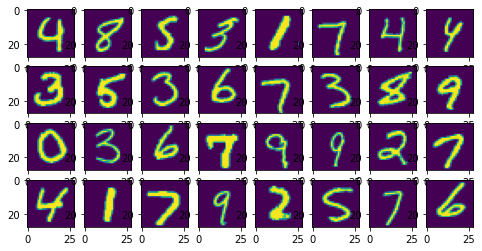

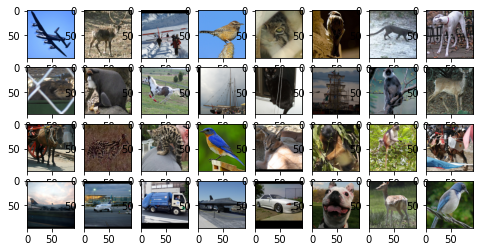

In [34]:
def show(imgs):
    # your code goes here:
  plt.figure(figsize=(8, 4))
  for i, item in enumerate(imgs):
      if i >= 32:
#        print('indexes error')
        break
      plt.subplot(4, 8, i+1)
#      img = item.numpy().transpose((1, 2, 0))
      plt.imshow(item)
#      plt.imshow(item[0].squeeze().numpy())

  return None

def show_random_images(imgs_nparray, N):
  xs = []
  for i in range(N):
    sample_idx = torch.randint(len(imgs_nparray), size=(1,)).item()
    img = imgs_nparray[sample_idx]
    xs.append(img)
  show(xs)

print('Random MNIST images:')
show_random_images(mnist_train_split.data, 32)
print('Random STL10 images:')
show_random_images(stl10_train_split, 32)



## Extrapolate in the image domain:

Here, randomly take 2 images from the training dataset, combine them together and plot the result. For example, consider $X_1$ and $X_2$ to be 2 images randomly taken from the training data. Plot $\alpha\cdot X_1 + (1-\alpha)\cdot X_2$. 

Explain the results, is extrapolation in the image domain reasonable?

Note: Recall that the images should be in the $[0,1]$ interval.

Extrapolate MNIST images in the image domain:
img.shape: torch.Size([28, 28])
Extrapolate STL10 images in the image domain:
img.shape: (96, 96, 3)


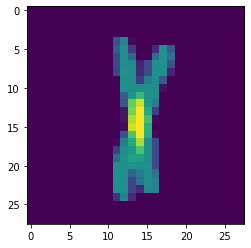

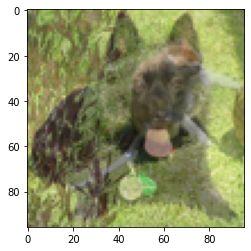

In [35]:
def extrapolte_images(imgs_nparray):
  sample_idx = torch.randint(len(imgs_nparray), size=(1,)).item()
  img1 = imgs_nparray[sample_idx]
  sample_idx = torch.randint(len(imgs_nparray), size=(1,)).item()
  img2 = imgs_nparray[sample_idx]
  alpha = 0.5

  img = alpha*img1 + (1-alpha)*img2
#  img = img3.numpy().transpose((1, 2, 0))
  plt.figure(clear=True)
  plt.imshow(img)
  print(f'img.shape: {img.shape}')

print('Extrapolate MNIST images in the image domain:')
extrapolte_images(mnist_train_split.data)
print('Extrapolate STL10 images in the image domain:')
extrapolte_images(stl10_train_split)



# Section 3 VAE

## VAE Foundations


## ELBO
 A we see above, the $ELBO = -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$ is comprised of 2 terms. Explain the meaning of each one of them in terms of a loss function.



**Minimizing** the loss function, over a batch in the dataset now can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

## VAE Implementation

As seen in class, a suitable way to extract features from dataset of images is by convolutional neural network (CNN). Hence, here you will build a convolutional VAE.
\
The basic idea is to start from full resolution images, and by convolutional kernels extract the important features of the dataset. Remember that the output of the VAE should be in the same dimensions $(H_1,W_1,C_1)$ as the input images. 

**The encoder** should be comprised of convolutional layers (nn.Conv2d). Recall that the dimension of the input images is changing according to:

$Z = \bigg(H_2(=\frac{H_1-F+2P}{S}+1),W_2(=\frac{W_1-F+2P}{S}+1),C_2\bigg)$

where $S$ is the stride, $F$ is the kernel size, $P$ is the zero padding and $C_2$ is the selected output channels. $Z$ is the output image.

**The decoder** should reconstruct the images from the latent space. In order to enlarge dimensions of images, your network should be comprised of transposed convolutional layers (nn.ConvTranspose2d). See the following images of the operation of transpose convolution to better understand the way it works.




***Transposed Convolution with Stride = 1***

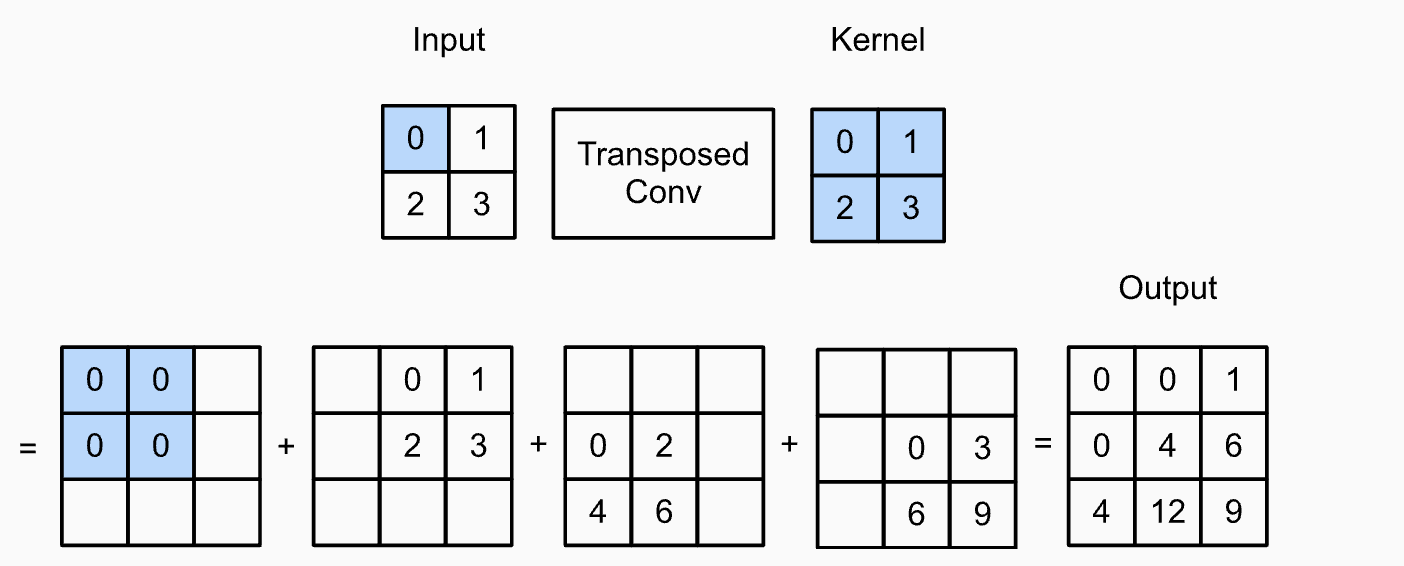

***Transposed Convolution with Stride = 2***
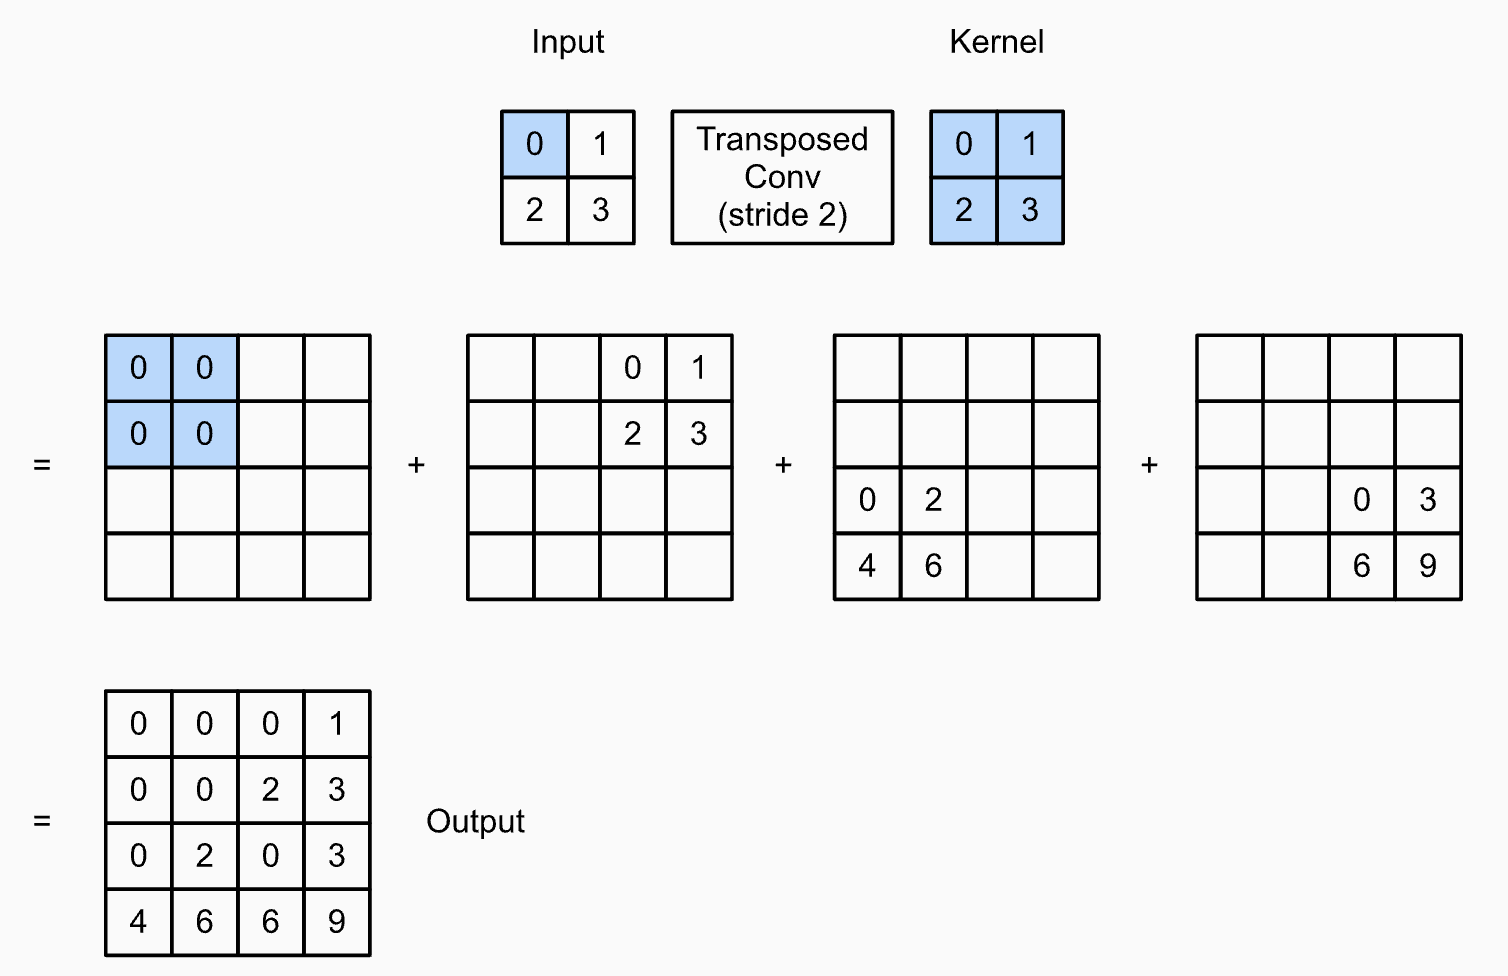

The architecture of your VAE network should be in the following form:


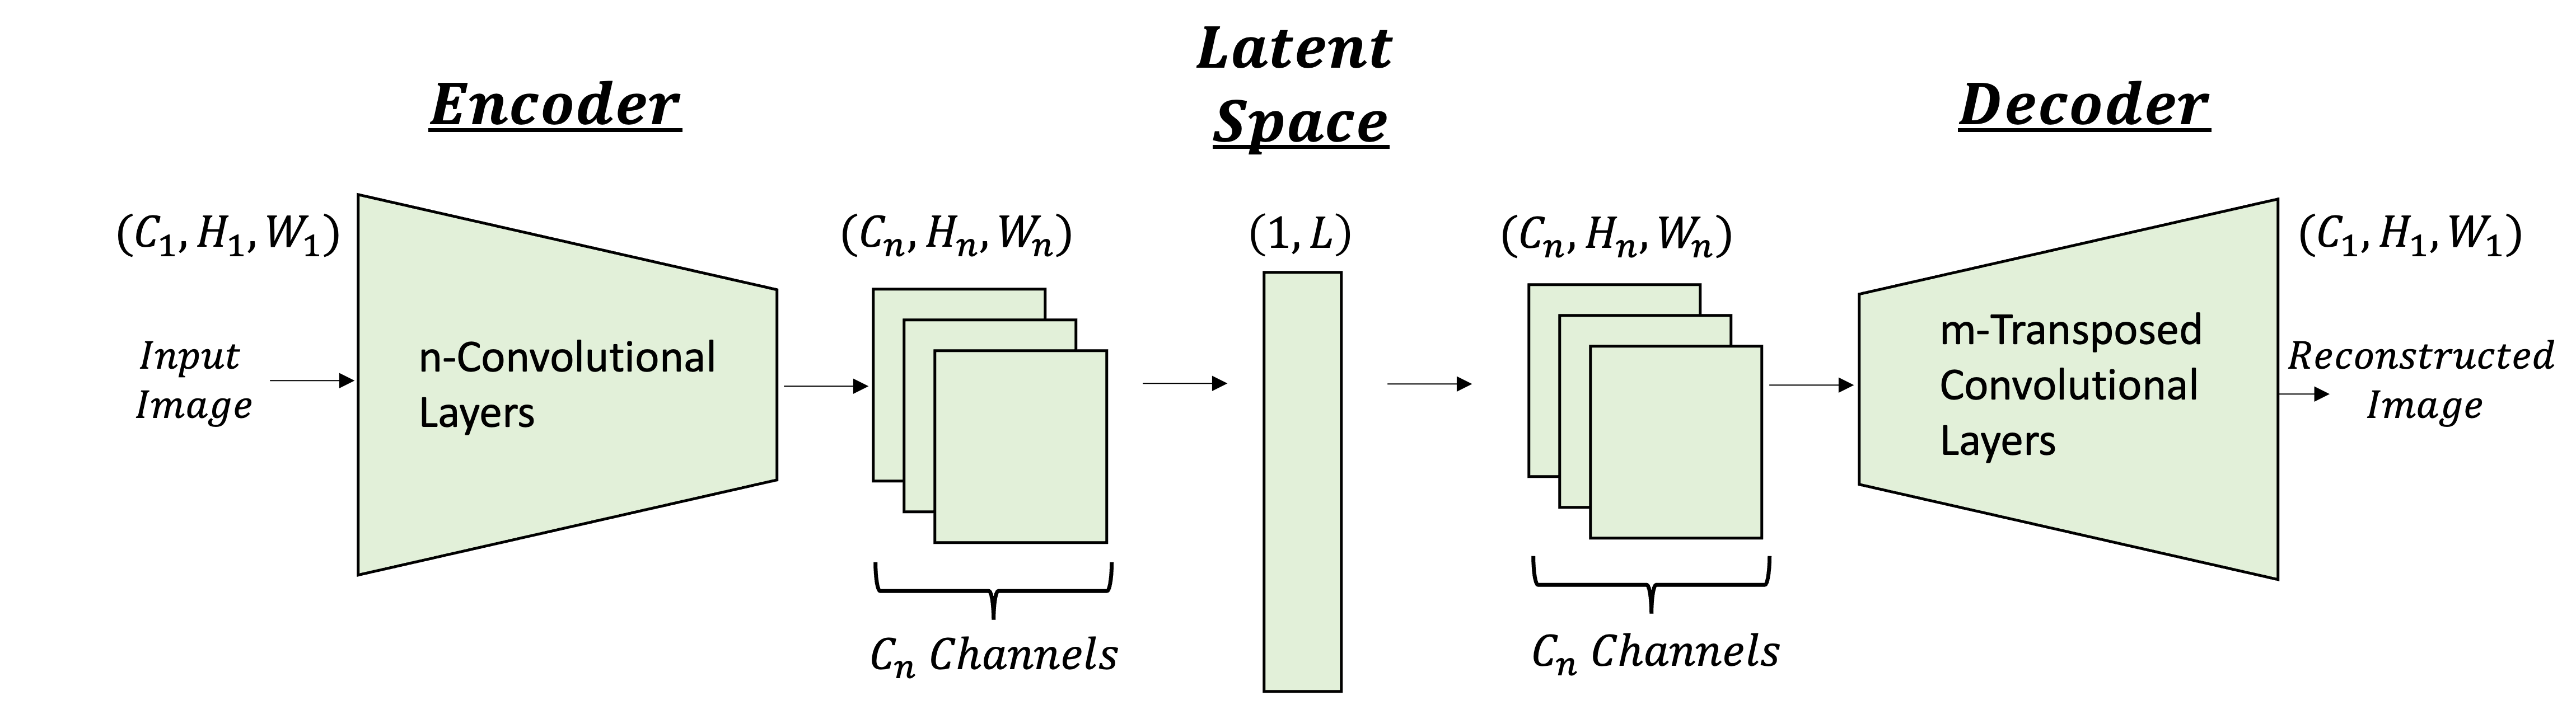

### Encoder

Here, you will implement the architecture of the encoder. 

The encoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Convolutional layer (nn.Conv2D(in_channels, num_hidden, kernel_size=(3,3), stride=(2,2)))
- Batch Normalization(num_hidden)
- Activation Function: nn.ReLU()

BLOCK 2: 
- Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 2)
- Activation Function: nn.ReLU()

BLOCK 3: 
- Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 4)
- Activation Function: nn.ReLU()

BLOCK 4: 
- Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 8)
- Activation Function: nn.ReLU()

In addidion to the 4 Blocks, you should add the following linear layers:

Linear $\mu$: 
- nn.Linear( ___ ,latent). 

Linear $\log(\sigma)$: 
- nn.Linear( ___ ,latent).

**NOTES:** 

- The input of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output from the 4'th block to $(Batch\cdot H_4\cdot W_4\cdot C_4 , latent)$, where $(Batch$ is the batch size, $H_4$ is the height of the output image from the 4'th block, $W_4$ is the width of the output image from the 4'th block and $C_4$ is num_hidden*8 (number of channels of the output image from the 4'th block).

**You can change any parameter of the network to suit your code - this is only a recommendation.**

In [36]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent, input_shape=(1, 28, 28)):
        super(Encoder, self).__init__()
        # YOUR CODE GOES HERE:
        print(f'Encoder: in_channels: {in_channels}, num_hiddens: {num_hiddens}, latent: {latent}, input_shape: {input_shape}')
        self.kernel_size = 3
        self.stride = 2
        self.in_channels = in_channels
        padding_num = int((self.kernel_size-1)/2)
        self.padding = (padding_num, padding_num)
        self.C, self.H, self.W = input_shape

        self.num_hiddens = num_hiddens
        self.latent = latent
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens),
            nn.ReLU()
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*2)
            nn.BatchNorm2d(num_hiddens*2),
            nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(num_hiddens * 2, num_hiddens * 4, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*4)
            nn.BatchNorm2d(num_hiddens*4),
            nn.ReLU()
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(num_hiddens * 4, num_hiddens * 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*8)
            nn.BatchNorm2d(num_hiddens*8),
            nn.ReLU()

        )
        self.flatten = torch.nn.Flatten()
        self.relu = torch.nn.ReLU()
      # after 4 Conv2D with stride=(2,2), the image shape is (h/(2**4),w/(2**4)), with 8*num_hiddens channels
      # thus, Linear input shape: (8*num_hiddens)*((self.H*self.W)/(2**8))
        fc1_inp = int((8*self.num_hiddens)*((self.H*self.W)/(2**8)))

        # n_linear_size = int(((image_h-3)/2 + 1)**2)
        print(f'fc1_inp: {fc1_inp}')
        self.fc_mu = nn.Linear(fc1_inp, latent)     # Insert the input size
        self.fc_logvar = nn.Linear(fc1_inp, latent) # Insert the input size

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'encoder forward: inputs.shape: {inputs.shape}')
        x = self.block1(inputs)
        if DEBUG_NN:
          print(f'block1(x): x.shape: {x.shape}')

        x = self.block2(x)
        if DEBUG_NN:
          print(f'block2(x): x.shape: {x.shape}')

        x = self.block3(x)
        if DEBUG_NN:
          print(f'block3(x): x.shape: {x.shape}')

        x = self.block4(x)
        if DEBUG_NN:
          print(f'block4(x): x.shape: {x.shape}')

        #x.view(-1, image_h*image_w*3), self.num_hiddens, self.latent
        x = self.flatten(x)
        if DEBUG_NN:
          print(f'flatten(x): x.shape: {x.shape}')
#        print(f'fc1(x): z.shape: {z.shape}')
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        if DEBUG_NN:
          print(f'encoder forward: fc_logvar(x): mu.shape, logvar.shape: {mu.shape}, {logvar.shape}')
        return mu, logvar

**Notice: We output $\log\sigma$ and not $\sigma^2$, this is a convention when training VAEs but it is completely equivalent.**

### Decoder

Here, you will implement the architecture of the decoder. 

First, Apply a linear layer to the input of the decoder as follows:

- nn.Linear(latent, ___ ).

The output of the linear layer should match to $Batch\cdot H_4\cdot W_4\cdot C_4$, which were the same parameters from the encoder 4'th block's output.

Then, the decoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Transposed Convolutional layer (nn.ConvTranspose2d(in_channels, num_hidden // 2, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 2)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 2: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 2, num_hidden // 4, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 4)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 3: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 4, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 4: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 8, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()


Afterwards, we should generate an image in the same size as our input images. Thus add 1 more block consisting of:

BLOCK 5:
 - nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
 - Activation function.

**NOTES:** 

- The output of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the  transposed convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output of the linear layer to ($Batch, H_4, W_4, C_4$)

- The output of the decoder should be of values in $[0,1]$.



**You can change any parameter of the network to suit your code, this is only a recommendation.**

In [37]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens,latent, input_shape=(1, 28, 28)):
        super(Decoder, self).__init__()
        # YOUR CODE GOES HERE:
        print(f'Decoder: in_channels: {in_channels}, num_hiddens: {num_hiddens}, latent: {latent}, input_shape: {input_shape}')
        self.kernel_size = 4
        self.stride = 2
        self.in_channels = in_channels
        padding_num = int((self.kernel_size-1)/2)
        self.padding = (padding_num, padding_num)
        self.C, self.H, self.W = input_shape

        self.latent = latent
        self.num_hiddens = num_hiddens

        # after 4 Conv2D with stride=(2,2), the image shape is (h/(2**4),w/(2**4)), with 8*n channels
        # thus, Linear input shape: (8*n)*((self.H*self.W)/(2**8))
        fc1_inp = int((8*self.num_hiddens)*((self.H*self.W)/(2**8)))
        img_s = (self.H*self.W)//2**8

        self.fc_dec = nn.Linear(latent, fc1_inp) # Insert the output size

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(fc1_inp // img_s, num_hiddens // 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 2),
            nn.LeakyReLU(0.1)
            )
        
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 2, num_hiddens // 4, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 4),
            nn.LeakyReLU(0.1)
            )

        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 4, num_hiddens // 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 8),
            nn.LeakyReLU(0.1)
            )
        
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 8, num_hiddens // 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 8),
            nn.LeakyReLU(0.1)
            )

        self.block5 = nn.Sequential( # Add convolution layer and activation layer
            nn.Conv2d(num_hiddens // 8, 3, kernel_size=(3,3), stride=(1,1), padding=1),
            # Batch Normalization(num_hidden)
            nn.LeakyReLU(0.1)
            )

        self.flatten = torch.nn.Flatten()
        self.le_relu = torch.nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'decoder forward: inputs.shape: {inputs.shape}')

        x = self.fc_dec(inputs)
        if DEBUG_NN:
          print(f'fc_dec(x): x.shape: {x.shape}')

        H = int(self.H/(2**4))
        W = int(self.W/(2**4))
        C = int(8*self.num_hiddens)
        x = x.reshape(-1,C,H,W)
#        x = x.view(N,C,H,W)
        if DEBUG_NN:
          print(f'reshaped x: x.shape: {x.shape}')


        x = self.block1(x)
        if DEBUG_NN:
          print(f'block1(x): x.shape: {x.shape}')

        x = self.block2(x)
        if DEBUG_NN:
          print(f'block2(x): x.shape: {x.shape}')

        x = self.block3(x)
        if DEBUG_NN:
          print(f'block3(x): x.shape: {x.shape}')

        x = self.block4(x)
        if DEBUG_NN:
          print(f'block4(x): x.shape: {x.shape}')

        x = self.block5(x)
        if DEBUG_NN:
          print(f'block5(x): x.shape: {x.shape}')

        x_rec = self.sigmoid(x)
        if DEBUG_NN:
          print(f'decoder forward: sigmoid(x): x_rec.shape: {x_rec.shape}')

        return x_rec

### VAE Model

Once you have the architecture of the encoder and the decoder, we want to put them together and train the network end-to-end.

Remember that in VAEs, you need to sample from a gaussian distribution at the input of the decoder. In order to backpropagate through the network, we use the reparametrization trick. The reparametrization trick is saying that sampling from $𝑧∼N(\mu,\sigma)$ is equivalent to sampling $\varepsilon∼N(0,1)$ and setting $𝑧=\mu+\sigma⊙\varepsilon$. Where, epsilon is an input to the network while keeping your sampling operation differentiable.
The reparametrization function is given to you in the VAE class.

Here, you should write the *forward()* function and to combine all the model's settings to a final network.

In [38]:
class VAE(nn.Module):
    def __init__(self, enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent, input_shape=(1, 28, 28)):
        super(VAE, self).__init__()
        self.num_hidden = dec_num_hidden
        self.latent = latent
        self.encode = Encoder(in_channels = enc_in_chnl, num_hiddens = enc_num_hidden,latent = latent, input_shape = input_shape)
        self.decode = Decoder(in_channels = dec_in_chnl, num_hiddens = dec_num_hidden,latent = latent, input_shape = input_shape)

    # Reparametrization Trick
    def reparametrize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)     
      return eps.mul(std).add_(mu)

    # Initialize Weights
    def weight_init(self, mean, std):
        for m in self._modules:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

    def forward(self, x):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'VAE forward: inputs.shape: {x.shape}')

        mu, logvar = self.encode(x)
        if DEBUG_NN:
          print(f'VAE forward: mu.shape, logvar.shape: {mu.shape}, {logvar.shape}')
        z = self.reparametrize(mu, logvar)
        if DEBUG_NN:
          print(f'z.shape: {z.shape}')

        x_rec = self.decode(z)
        if DEBUG_NN:
          print(f'VAE forward: x_rec.shape: {x_rec.shape}')

        return x_rec , mu, logvar


### Loss Function

As we saw earlier, the loss function is based on the ELBO; Over a batch in the dataset, it can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

**$\beta$-Variational Autoencoder ($\beta$-VAE)**

As seen in class, the fact that the ELBO is comprised of the sum of two loss terms implies that these can be balanced using an additional hyperparameter $\beta$, i.e.,

$\beta\cdot D_{KL}\big(q(z|x_i)||P(z)\big) - E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$

It is highly recommended to use the $\beta$-loss for increasing performance. 
 


Explain what could be the purpose of the hyperparameter $\beta$ in the loss function? If $\beta = 1$ is same as VAE, What is the effect of $\beta \neq 1$?

The DKL term is regularization term, and the E() is reconstruction term. The hyperparameter $\beta$ in the loss function that controls the balance between these two terms. With $\beta < 1$,
the reconstruction term has stronger effect on the ELBO result. It will cause the trained model to emphisize the reconstruction of the inputs  over the latent regularization. Very small $\beta$ value can cause the model overfitting.
With high $\beta$ the trained model will prefer the regularization term that might cause to poor reconstruction results and lead to underfitting.
We use large $\beta < 1$ to cause the model training to emphisize on KLD, since we are less interested in recosntruction quality.


In [39]:
beta = 0.8
def vae_loss(x_recon, x, mu, logvar):
# Reconstruction + KL divergence losses summed over all elements and batch
    if DEBUG_NN:
      print(f'vae_loss: x_recon.shape, x.shape: {x_recon.shape}, {x.shape}')
    MSE = nn.functional.mse_loss(
        x, x_recon, reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    
    return MSE + KLD*beta


 Here, define all the hyperparameters values for the training process. 

We gave you recommended values for the VAE model. You can modify and change it to suit your code better if needed.

## VAE Training



### Training function

In [40]:
#def plot_learning_curve(iters, losses, epocs_vec, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg):
def plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(epocs_vec, train_losses, label="Train")

    plt.plot(epocs_vec, test_losses, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


In [41]:
def train(dataset, model, train_loader, test_loader, num_epochs=10, learning_rate=1e-3, batch_size=10, train_dataset_size=64, test_dataset_size=64):
    '''  
    This is a starter code for the training process. You can modify it for your 
    own conveinient.
    num_epochs - number of training epochs
    batch_size - size of the batches
    dataset_size - How many training samples to use. 
    model - The model you are training.   

    Note: decide what are the outputs of the function. 
    '''

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_iters, test_iters, train_losses, test_losses, epocs_vec = [], [], [], [], []
    codes = dict(μ=list(), logσ2=list(), label=list())
    model.train()
    n = 0 # total number of iterations
    nt = 0 # total number of test iterations
    img = None
    x_recon = None

    for epoch in range(num_epochs):
      train_loss = 0
      for batch_idx, batch in enumerate(train_loader):
        if dataset == 'Mnist':
          imgs, y = batch
        else:
          imgs = batch
          # reshape - for STL10
          N, H, W, C = imgs.shape
          imgs = imgs.view(N,C,H,W)
#        print(f'train imgs11.shape: {imgs11.shape}')
        imgs = imgs.to(dev)
        if DEBUG:
          print(f'train imgs.shape: {imgs.shape}')

#        print(f'train imgs.shape: {imgs.shape}')
        # Since the dataset is large, train on 'train_dataset_size' samples.
        if train_dataset_size//batch_size == batch_idx: 
            break


        # ===================forward=====================
        x_recon, mu, logvar = model(imgs)
        loss = vae_loss(x_recon, imgs, mu, logvar)
        train_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        n += 1
        train_iters.append(n)

      # Testing - once per epoch
      means, logvars = list(), list()
      with torch.no_grad():
          model.eval()
          test_loss = 0
          for batch_idx, batch in enumerate(test_loader):
              if dataset == 'Mnist':
                img, y = batch
              else:
                img = batch
                N, H, W, C = img.shape
                img = img.view(N,C,H,W)
              img = img.to(dev)
              # Since the test dataset is large, train on 'test_dataset_size' samples.
              if test_dataset_size//batch_size == batch_idx: 
                  break
              if DEBUG:
                print(f'test img.shape: {img.shape}')
              # ===================forward=====================
              x_recon, mu, logvar = model(img)
              test_loss += vae_loss(x_recon, img, mu, logvar).item()
              # =====================log=======================
              # save the current training information
              nt += 1
              test_iters.append(nt)

              means.append(mu.detach())
              logvars.append(logvar.detach())
          # ===================log========================
          codes['μ'].append(torch.cat(means))
          codes['logσ2'].append(torch.cat(logvars))


        # ===================log========================
      epocs_vec.append(epoch)
      test_loss = float(test_loss)/test_dataset_size
      train_loss = float(train_loss)/train_dataset_size
      test_losses.append(test_loss)  # compute *average* loss
      train_losses.append(train_loss)  # compute *average* loss
      print(f"Epoch {epoch}, Train Iter {n}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}")


    # saved statistics and the last batch
    return train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img


# Train


 ## Train STL10 VAE

### latent space $L = 3$


Encoder: in_channels: 3, num_hiddens: 32, latent: 3, input_shape: (3, 96, 96)
fc1_inp: 9216
Decoder: in_channels: 32, num_hiddens: 256, latent: 3, input_shape: (3, 96, 96)
Epoch 0, Train Iter 100, train_loss: 1641.4404, test_loss: 1508.8736
Epoch 1, Train Iter 200, train_loss: 1519.1177, test_loss: 1467.9599
Epoch 2, Train Iter 300, train_loss: 1351.6169, test_loss: 1264.7221
Epoch 3, Train Iter 400, train_loss: 1250.5601, test_loss: 1232.4849
Epoch 4, Train Iter 500, train_loss: 1234.3969, test_loss: 1217.9475
Epoch 5, Train Iter 600, train_loss: 1217.9858, test_loss: 1199.2060
Epoch 6, Train Iter 700, train_loss: 1202.8619, test_loss: 1190.5995
Epoch 7, Train Iter 800, train_loss: 1193.2740, test_loss: 1186.0779
Epoch 8, Train Iter 900, train_loss: 1190.0644, test_loss: 1173.1727
Epoch 9, Train Iter 1000, train_loss: 1182.8410, test_loss: 1184.4890


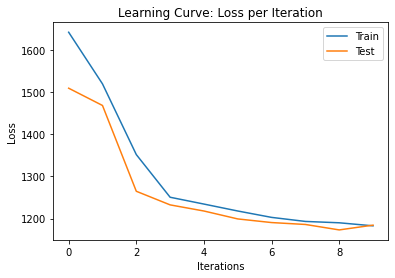

In [42]:
# Your Code Goes Here
def train_stl10_toy():
  learning_rate = 2e-3
  batch_size = 50
  num_epochs = 10
  #dataset_size = 30000 # How many data samples to use for training, 30,000 should be enough.
  dataset_size = 600 # How many data samples to use for training, 30,000 should be enough.
  train_dataset_size = stl10_train_split.shape[0]
  test_dataset_size = stl10_test_split.shape[0]
  #train_dataset_size = 3000
  #test_dataset_size = 1000

  #VAE Class inputs: 
  enc_in_chnl = 3
  enc_num_hidden = 32
  dec_in_chnl = 32
  dec_num_hidden = 256
  latent1 = 3

  #mnist_test_split, mnist_train_split = None, None
  #stl10_test_split, stl10_train_split = None, None

  # Train STL10
  # set STL10 image size
  # image shape
  #HEIGHT = 96
  #WIDTH = 96
  #DEPTH = 3
  image_shape = (3, 96, 96)
  # resize the images


  train_loader = torch.utils.data.DataLoader(stl10_train_split, batch_size=batch_size, shuffle=True) 
  test_loader = torch.utils.data.DataLoader(stl10_test_split, batch_size=batch_size, shuffle=True) 

  model_1 = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent1, input_shape=image_shape)
  model_1.to(dev)
  model_1.weight_init(mean=0, std=0.02)
  train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img = train('STL10',
      model_1, train_loader, test_loader, num_epochs,
      learning_rate, batch_size, train_dataset_size, test_dataset_size)
  plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec)
  return model_1, x_recon, img

DEBUG = False
DEBUG_NN = False

model_1, x_recon_stl10, img_stl10 = train_stl10_toy()


### Visualize reconstructed images

As we can see from the reconstruction results below, the reconstruction quality is poor. The reconstructed images look very blur. It seems that latent of dimension 3 is not able to capture the mappings from trained images to the AE latent domain.

img.shape: torch.Size([50, 3, 96, 96])
in_pics.shape: torch.Size([50, 3, 96, 96])


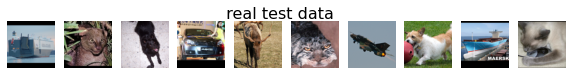

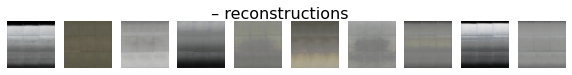

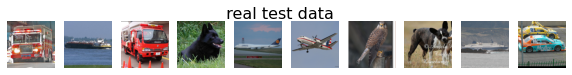

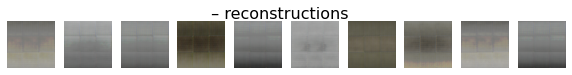

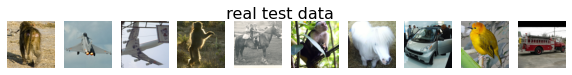

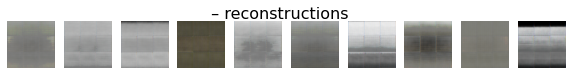

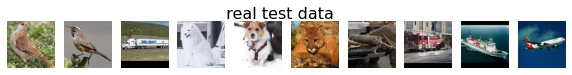

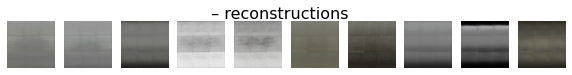

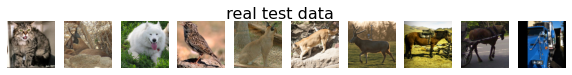

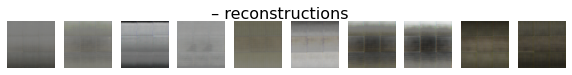

In [43]:
def display_images(imgs, x_recon = None, X=1, label='', count=False):
    in_pics = imgs.data.cpu()
    if x_recon is not None:
      out_pics = x_recon.data.cpu()
    print(f'in_pics.shape: {in_pics.shape}')
    Y = len(in_pics)//X
    for i in range(X):
      plt.figure(figsize=(10, 1.1))
      plt.suptitle(label + ' real test data', fontsize=16)
      for j in range(Y):
          plt.subplot(1,Y,j+1)

          N, C, H, W = in_pics.shape
          in_pic = in_pics.view(N,H,W,C)[j+Y*i]
          plt.imshow(in_pic)
          plt.axis('off')
      if x_recon is not None:
          plt.figure(figsize=(10, 1.1))
          plt.suptitle(label + ' – reconstructions', fontsize=16)
          for j in range(Y):
              plt.subplot(1,Y,j+1)
              N, C, H, W = out_pics.shape
              out_pic = out_pics.view(N,H,W,C)[j+Y*i]
              plt.imshow(out_pic)
              plt.axis('off')


#print(f'Sample images:')
#show(img.cpu())
#print(f'Recon of Sample images:')
#show(x_recon.cpu())
print(f'img.shape: {img_stl10.shape}')
display_images(img_stl10, x_recon_stl10, X=5, label='', count=False)


### latent space $L > 3$

Next, we train with larger $L > 3$

Based on the results for $L = 3$, choose a larger $L$ to improve your results.
Train new model with your choice for $L$.

train_dataset_size: 5000, test_dataset_size: 8000
Encoder: in_channels: 3, num_hiddens: 32, latent: 200, input_shape: (3, 96, 96)
fc1_inp: 9216
Decoder: in_channels: 32, num_hiddens: 256, latent: 200, input_shape: (3, 96, 96)
Epoch 0, Train Iter 100, train_loss: 2351.4418, test_loss: 1754.7399
Epoch 1, Train Iter 200, train_loss: 1696.9252, test_loss: 1526.0529
Epoch 2, Train Iter 300, train_loss: 1499.5174, test_loss: 1477.4791
Epoch 3, Train Iter 400, train_loss: 1390.7956, test_loss: 1280.7902
Epoch 4, Train Iter 500, train_loss: 1241.7244, test_loss: 1206.7284
Epoch 5, Train Iter 600, train_loss: 1191.7579, test_loss: 1153.8309
Epoch 6, Train Iter 700, train_loss: 1125.2069, test_loss: 1090.9502
Epoch 7, Train Iter 800, train_loss: 1084.6149, test_loss: 1068.2122
Epoch 8, Train Iter 900, train_loss: 1061.1435, test_loss: 1045.1659
Epoch 9, Train Iter 1000, train_loss: 1041.9916, test_loss: 1038.4709
Epoch 10, Train Iter 1100, train_loss: 1036.5703, test_loss: 1025.0354
Epoch 11, Tr

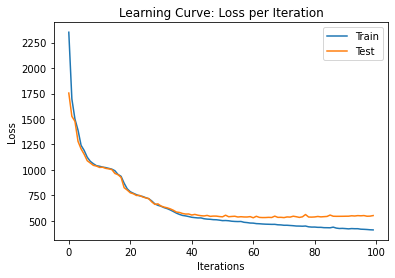

In [44]:
def train_stl10():

  learning_rate = 2e-3
  batch_size = 50
  num_epochs = 100

  #mnist_test_split, mnist_train_split = None, None
  #stl10_test_split, stl10_train_split = None, None
  train_dataset_size = stl10_train_split.shape[0]
  test_dataset_size = stl10_test_split.shape[0]
  print(f'train_dataset_size: {train_dataset_size}, test_dataset_size: {test_dataset_size}')
  DEBUG = False
  DEBUG_NN = False

  #VAE Class inputs: 
  enc_in_chnl = 3
  enc_num_hidden = 32
  dec_in_chnl = 32
  dec_num_hidden = 256
  latent2 = 200


  # Train STL10
  # set STL10 image size
  # image shape
  #HEIGHT = 96
  #WIDTH = 96
  #DEPTH = 3
  image_c, image_h, image_w = (3, 96, 96)
  image_size = (96, 96)
  # resize the images
  image_shape = (3, 96, 96)


  train_loader = torch.utils.data.DataLoader(stl10_train_split, batch_size=batch_size, shuffle=True) 
  test_loader = torch.utils.data.DataLoader(stl10_test_split, batch_size=batch_size, shuffle=True) 

  model_2 = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent2, input_shape=image_shape)
  model_2.to(dev)
  model_2.weight_init(mean=0, std=0.02)
  train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img = train('STL10',
      model_2, train_loader, test_loader, num_epochs,
      learning_rate, batch_size, train_dataset_size, test_dataset_size)
  plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec)
  return model_2, x_recon, img

model_2_stl10, x_recon, img = train_stl10()


in_pics.shape: torch.Size([50, 3, 96, 96])


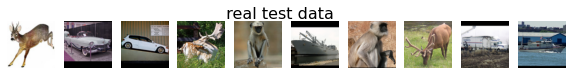

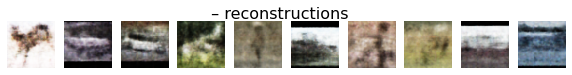

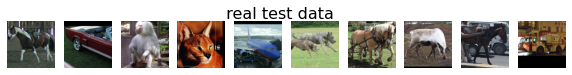

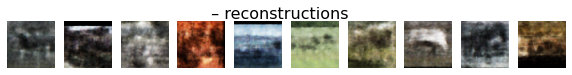

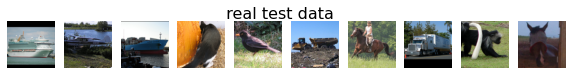

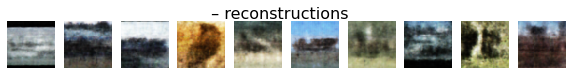

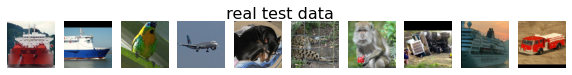

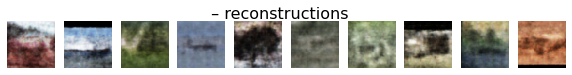

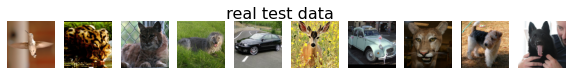

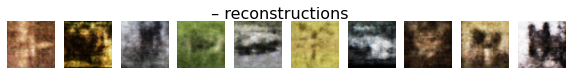

In [45]:
imgs_stl1 = img[:50]
x_recon_stl1 = x_recon[:50]
display_images(imgs_stl1, x_recon_stl1, X=5, label='', count=False)


## Train MNIST VAE

### latent space $L = 3$


train_dataset_size: 12000, test_dataset_size: 2000
Encoder: in_channels: 1, num_hiddens: 32, latent: 3, input_shape: (1, 32, 32)
fc1_inp: 1024
Decoder: in_channels: 32, num_hiddens: 256, latent: 3, input_shape: (1, 32, 32)


<ipython-input-39-0ab288fafb6b>:7: UserWarning: Using a target size (torch.Size([50, 3, 32, 32])) that is different to the input size (torch.Size([50, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  MSE = nn.functional.mse_loss(


Epoch 0, Train Iter 240, train_loss: 196.1272, test_loss: 116.6181
Epoch 1, Train Iter 480, train_loss: 104.1340, test_loss: 99.3074
Epoch 2, Train Iter 720, train_loss: 95.7411, test_loss: 90.7243
Epoch 3, Train Iter 960, train_loss: 92.3931, test_loss: 89.7048
Epoch 4, Train Iter 1200, train_loss: 89.9802, test_loss: 87.9703
Epoch 5, Train Iter 1440, train_loss: 86.8900, test_loss: 87.7596
Epoch 6, Train Iter 1680, train_loss: 85.6218, test_loss: 88.4077
Epoch 7, Train Iter 1920, train_loss: 86.1980, test_loss: 85.2320
Epoch 8, Train Iter 2160, train_loss: 84.9936, test_loss: 83.6327
Epoch 9, Train Iter 2400, train_loss: 83.7042, test_loss: 83.4624


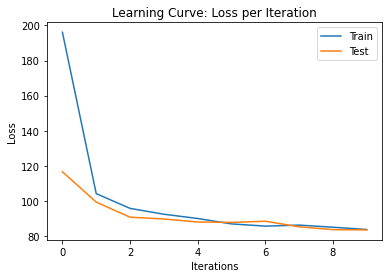

In [46]:
# Train MNIST
def train_mnist_toy():
  # Your Code Goes Here
  learning_rate = 2e-3
  batch_size = 50
  num_epochs = 10
  #dataset_size = 30000 # How many data samples to use for training, 30,000 should be enough.
  dataset_size = 600 # How many data samples to use for training, 30,000 should be enough.
  train_dataset_size = mnist_train_split.data.shape[0]//5
  test_dataset_size = mnist_test_split.data.shape[0]//5
  #train_dataset_size = 3000
  #test_dataset_size = 1000
  print(f'train_dataset_size: {train_dataset_size}, test_dataset_size: {test_dataset_size}')

  #VAE Class inputs: 
  enc_in_chnl = 1
  enc_num_hidden = 32
  dec_in_chnl = 32
  dec_num_hidden = 256
  latent1 = 3

  #mnist_test_split, mnist_train_split = None, None
  #stl10_test_split, stl10_train_split = None, None

  # Train MNIST
  # set MNIST image size
  #image_c, image_h, image_w = (1, 28, 28)
  image_shape = (1, 32, 32)
#  image_size = (28, 28)
  # add channel dimension to image tensor

  train_loader = torch.utils.data.DataLoader(mnist_train_split, batch_size=batch_size, shuffle=True) 
  test_loader = torch.utils.data.DataLoader(mnist_test_split, batch_size=batch_size, shuffle=True) 

  model_1 = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent1, input_shape=image_shape)
  model_1.to(dev)
  model_1.weight_init(mean=0, std=0.02)
  train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img = train('Mnist',
      model_1, train_loader, test_loader, num_epochs,
      learning_rate, batch_size, train_dataset_size, test_dataset_size)
  plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec)
  return model_1, x_recon, img

#DEBUG = True
#DEBUG_NN = True
model_1_mnist, x_recon_mnist, imgs_mnist = train_mnist_toy()


### Visualize reconstructed images

in_pics.shape: (50, 1, 32, 32)


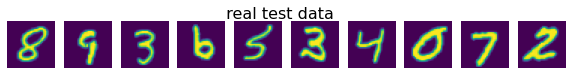

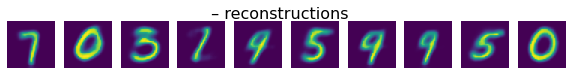

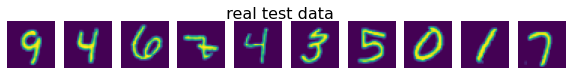

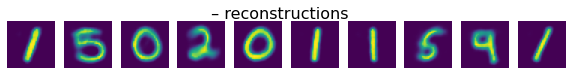

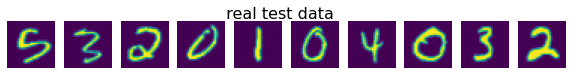

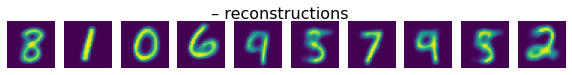

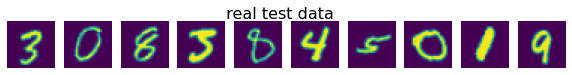

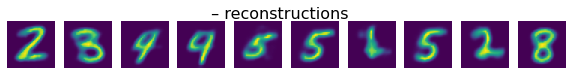

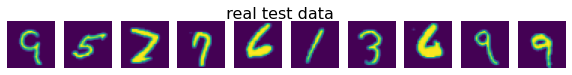

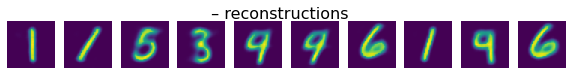

In [47]:
def display_images_mnist(imgs, x_recon = None, X=1, label='', count=False):
    in_pics = imgs.data.cpu()
    in_pics = in_pics.detach().numpy()
    if x_recon is not None:
      out_pics = x_recon.data.cpu()
      out_pics = out_pics.detach().numpy()
    print(f'in_pics.shape: {in_pics.shape}')
    Y = len(in_pics)//X
    for i in range(X):
      plt.figure(figsize=(10, 1.1))
      plt.suptitle(label + ' real test data', fontsize=16)
      for j in range(Y):
          plt.subplot(1,Y,j+1)
          in_pic = in_pics[j+Y*i,0]
          plt.imshow(in_pic)
          plt.axis('off')
      if x_recon is not None:
          plt.figure(figsize=(10, 1.1))
          plt.suptitle(label + ' – reconstructions', fontsize=16)
          for j in range(Y):
              plt.subplot(1,Y,j+1)
              out_pic = out_pics[j+Y*i,0]
              plt.imshow(out_pic)
              plt.axis('off')

display_images_mnist(imgs_mnist, x_recon_mnist, X=5, label='', count=False)


### latent space $L > 3$


Plot the train and the validation loss graphs. Explain what is seen.

Eventually, after playing with hyperparameters, we see stable training process with training loss going down on each iteration. We see unusually high loss values - thousands, hundreds. We tried to lower these numbers to be less than 1. It can be done by, for example, changing the 'sum' reduction in MSE loss calculation to 'mean', but it doesn't really improves the model performance, so we decided to stay as is.

train_dataset_size: 60000, test_dataset_size: 10000
Encoder: in_channels: 1, num_hiddens: 32, latent: 200, input_shape: (1, 32, 32)
fc1_inp: 1024
Decoder: in_channels: 32, num_hiddens: 256, latent: 200, input_shape: (1, 32, 32)


<ipython-input-39-0ab288fafb6b>:7: UserWarning: Using a target size (torch.Size([100, 3, 32, 32])) that is different to the input size (torch.Size([100, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  MSE = nn.functional.mse_loss(


Epoch 0, Train Iter 600, train_loss: 106.1696, test_loss: 49.8145
Epoch 1, Train Iter 1200, train_loss: 43.5739, test_loss: 40.0799
Epoch 2, Train Iter 1800, train_loss: 38.9439, test_loss: 37.6203
Epoch 3, Train Iter 2400, train_loss: 37.0348, test_loss: 36.1799
Epoch 4, Train Iter 3000, train_loss: 35.9218, test_loss: 35.3458
Epoch 5, Train Iter 3600, train_loss: 35.0548, test_loss: 34.8471
Epoch 6, Train Iter 4200, train_loss: 34.4153, test_loss: 34.2004
Epoch 7, Train Iter 4800, train_loss: 33.9603, test_loss: 33.6181
Epoch 8, Train Iter 5400, train_loss: 33.5182, test_loss: 33.2081
Epoch 9, Train Iter 6000, train_loss: 33.0989, test_loss: 33.1451
Epoch 10, Train Iter 6600, train_loss: 32.8421, test_loss: 33.0113
Epoch 11, Train Iter 7200, train_loss: 32.5295, test_loss: 32.7776
Epoch 12, Train Iter 7800, train_loss: 32.1994, test_loss: 32.3089
Epoch 13, Train Iter 8400, train_loss: 31.9889, test_loss: 32.7724
Epoch 14, Train Iter 9000, train_loss: 31.8292, test_loss: 31.8369
Epoch

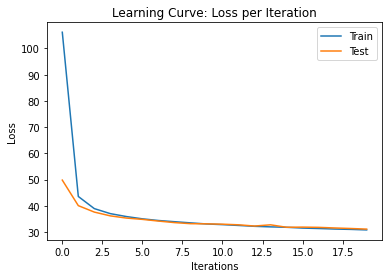

In [48]:
# Train MNIST
def train_mnist():
  # Your Code Goes Here
  learning_rate = 2e-3
  batch_size = 100
  num_epochs = 20
  train_dataset_size = mnist_train_split.data.shape[0]
  test_dataset_size = mnist_test_split.data.shape[0]
  #train_dataset_size = 3000
  #test_dataset_size = 1000
  print(f'train_dataset_size: {train_dataset_size}, test_dataset_size: {test_dataset_size}')

  #VAE Class inputs: 
  enc_in_chnl = 1
  enc_num_hidden = 32
  dec_in_chnl = 32
  dec_num_hidden = 256
  latent1 = 200

  #mnist_test_split, mnist_train_split = None, None
  #stl10_test_split, stl10_train_split = None, None

  # Train MNIST
  # set MNIST image size
  image_shape = (1, 32, 32)
  
  train_loader = torch.utils.data.DataLoader(mnist_train_split, batch_size=batch_size, shuffle=True) 
  test_loader = torch.utils.data.DataLoader(mnist_test_split, batch_size=batch_size, shuffle=True) 

  model_1 = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent1, input_shape=image_shape)
  model_1.to(dev)
  model_1.weight_init(mean=0, std=0.02)
  train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img = train('Mnist',
      model_1, train_loader, test_loader, num_epochs,
      learning_rate, batch_size, train_dataset_size, test_dataset_size)
  plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec)
  return model_1, x_recon, img

#DEBUG = True
#DEBUG_NN = True
model_2_mnist, imgs_mnist, x_recon_mnist = train_mnist()


Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Are the images identical? Explain.

in_pics.shape: (50, 3, 32, 32)


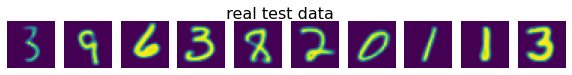

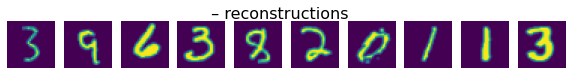

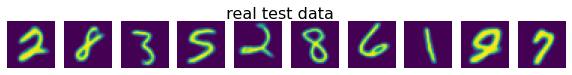

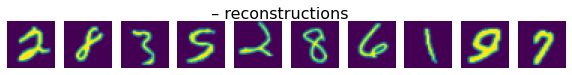

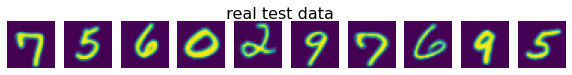

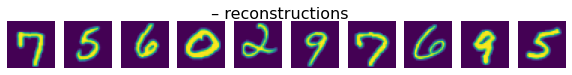

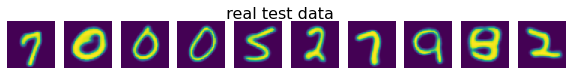

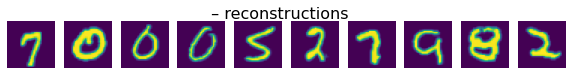

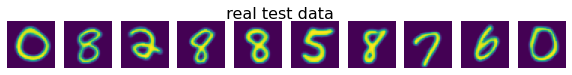

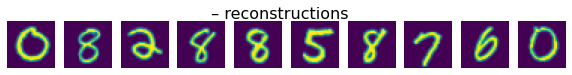

In [50]:
imgs_mnist1 = imgs_mnist[:50]
x_recon_mnist1 = x_recon_mnist[:50]
display_images_mnist(imgs_mnist1, x_recon_mnist1, X=5, label='', count=False)


 What will happened if we choose extremely high dimension for the latent space? 

## Save Trained Models

In [49]:
from google.colab import drive
drive.mount('/content/gdrive')

# Save model in GDrive for future use
if (model_path_stl10 is not None):
    torch.save(model_2_stl10.state_dict(), model_path_stl10)
if (model_path_mnist is not None):
    torch.save(model_2_mnist.state_dict(), model_path_mnist)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Write your explanation here
If you choose an extremely high dimension for the latent space in an generative models such as an Autoencoder or Variational Autoencoder, it can cause a few issues:
Overfitting: With a large latent space, the model has more capacity to fit to the training data, which can result in overfitting. This means that the model will perform well on the training data, but may not generalize well to new, unseen data.
Memory and computational cost: The more complex a model is, the more memory and computational resources it requires to train and run. This can make it difficult to work with large models.
High dimension also can lead to curse of dimensionality, which makes the optimization more difficult, and as result the model will converge very slowly.
Semantic meaning of the latent variables: When the latent space dimension is too high, it can be hard to interpret the semantic meaning of each latent variable.
Instead, it is better to keep the dimension of the latent space as low as possible while still maintaining the ability to reconstruct the original data accurately. This can be done by using techniques such as dimensionality reduction or feature selection, or by carefully designing the architecture of the model to have a smaller number of latent variables.

 
Did you output blurry reconstructed images? If the answer is yes, explain what could be the reason. If you got sharp edges and fine details, explain what you did in order to achieve that. 

Note: If you got blurry reconstructed images, just explain why. You dont need to change your code or retrain your model for better results (as long as your results can be interpreted as a human face).
 

### Write your explanation here
To improve reconsrtucted images sharpness, we increased several hyperparameters: dataset size, number of epochs, latent size.

Additional possible reasons for blurry reconstructed images are:
Insufficient data: If the training dataset is small or not diverse enough, the model may not be able to learn to reconstruct images with high accuracy.
Low resolution: If the original images used for training are low resolution, the model may not be able to reconstruct high-resolution images with sharp edges and fine details.
Model architecture: The architecture of the model (such as the number of layers and the type of layers used) can also impact the quality of the reconstructed images.
Hyperparameters: The specific settings used when training the model, such as the learning rate and batch size, can also affect the quality of the reconstructed images.
Training time: The number of training iteration and the data size also can be a factor to get blur images.
If you are training the model to reconstruct images with sharp edges and fine details, you may need to use a larger and more diverse training dataset, train with high-resolution images, use a more powerful model architecture, and experiment with different hyperparameter settings.

## Generate New Images

Now, for the fun part!

We are going to generate new celebrity faces with our VAE models. A function for new faces generation is given to you. Modify it (if needed) to fit your code. 



In [ ]:
# creates random noise sample in the correct shape.
def generate_faces(model, grid_size, latent):
    model.eval()
    dummy = torch.empty([batch_size,latent])
    z = torch.randn_like(dummy).to(device)

    #insert the random noise to the decoder to create new samples.
    sample = model.decode(z)
    print(f'sample.shape: {sample.shape}')

    new_face_list = []
    j=0
    while j < grid_size: 
        new_face_list.append(sample[j])
        j+=1

#    display_images(sample, X=5)

    grid = make_grid(new_face_list)
    print(f'grid.shape: {grid.shape}')
    grid = grid.cpu()
    grid = grid.numpy().transpose((1, 2, 0))
    print(f'grid.shape: {grid.shape}')
    plt.imshow(grid)

# Load model from GDrive if not trained
if (model_path_stl10 is not None):
    print(f'Load model_path_stl10 from GDrive')
    model_2_stl10.load_state_dict(torch.load(model_path_stl10))

generate_faces(model_2_stl10, grid_size=16, latent = 200)

**Model 1 ($L = 3$) results:**

sample.shape: torch.Size([50, 3, 64, 64])
grid.shape: torch.Size([3, 134, 530])
grid.shape: (134, 530, 3)


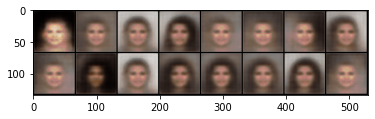

In [ ]:
generate_faces(model_2_stl10, grid_size=16, latent = 200)

**Model 2 results:**

sample.shape: torch.Size([50, 3, 64, 64])
grid.shape: torch.Size([3, 134, 530])
grid.shape: (134, 530, 3)


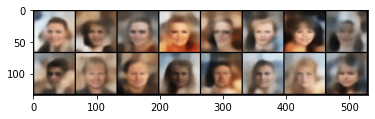

In [ ]:
#generate_faces(model_2_stl10, grid_size=16, latent = 200)

*Q1:* Generate new faces with VAE model with latent space dimension = 3. Did you get diverse results? What are the most prominent features that the latent space capture? 

*Q2:* Generate new faces with VAE model with your decision for latent space dimension. What are the most prominent features that the latent space capture? 

*Q3:* What are the differences? Your results are similar to the dataset images? Do you get realistic images for your chosen latent space dimension? If not, change your decision or your network to acheive more realistic results.

## Extrapolation in Latent Domain

Recall that we extrapolate in the images domain in Question 2, part (c).
Here, extrapolate in the latent space domain to generate new images.

Define $\beta = [0, 0.1, 0.2, ... , 0.9, 1]$ and randomly sample from $Z \sim \mathcal{N(0,1)}$ 2 different samples and generate 2 new face images: $X_1, X_2$.

Extrapolate in the latent domain as follows: $\beta_i\cdot Z_1 + (1-\beta_i)\cdot Z_2$ for each $\beta_i \in \beta$.

Plot the extrapolation of the images for each $\beta$ and discuss your results. 
Repeat the process for 3 different samples.



Extrapolate of the images in the latent domain makes perfect sense. Here the extarpolation is done not on original images pixels where the images can be very different, thus generating bad extrapolation results. While extrapolating in latent domain, we play with statiscical images features, thus generating much more sharp and smooth images that are much more similar to the original images.

img1.shape: torch.Size([3, 64, 64])
img.shape: (64, 64, 3)
img1.shape: torch.Size([3, 64, 64])
img.shape: (64, 64, 3)
img1.shape: torch.Size([3, 64, 64])


<ipython-input-25-1ac553615440>:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-25-1ac553615440>:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-25-1ac553615440>:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(clear=True)


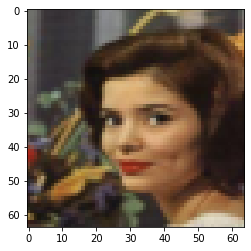

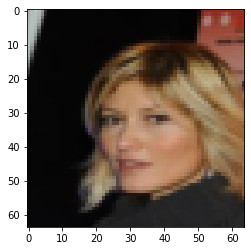

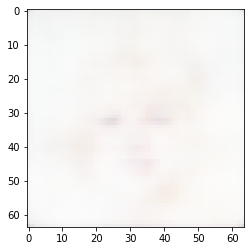

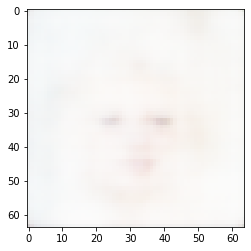

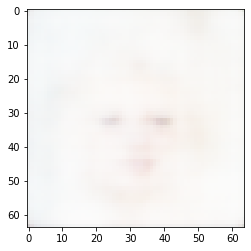

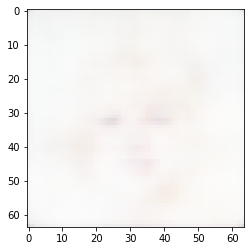

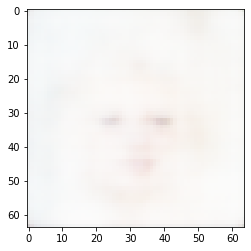

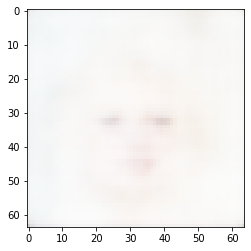

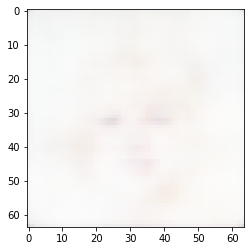

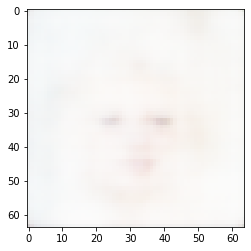

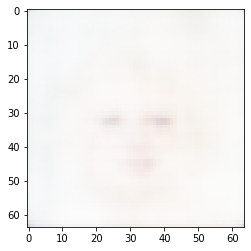

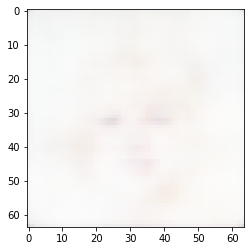

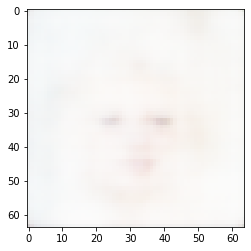

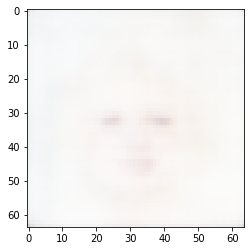

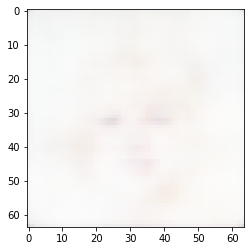

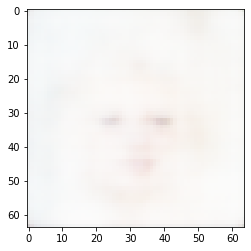

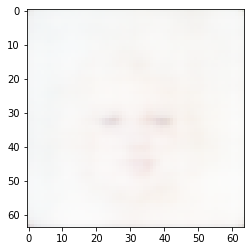

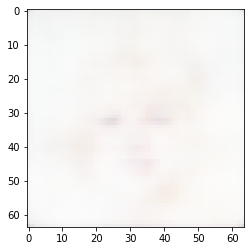

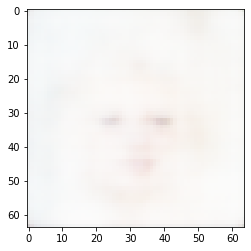

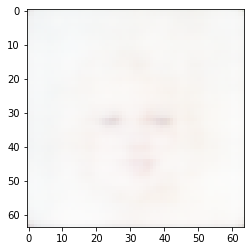

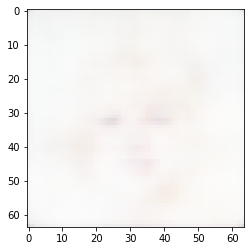

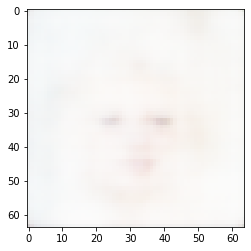

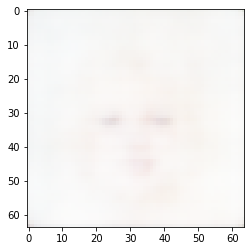

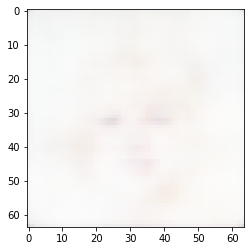

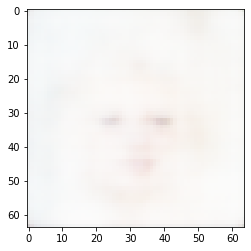

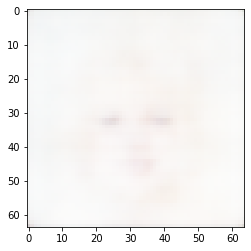

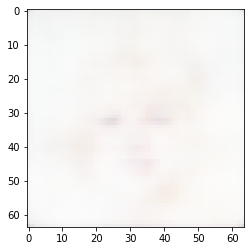

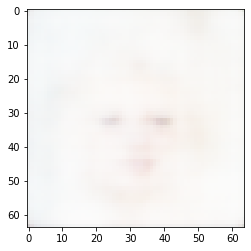

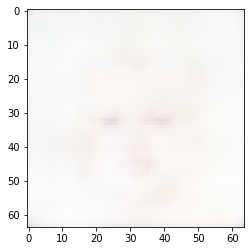

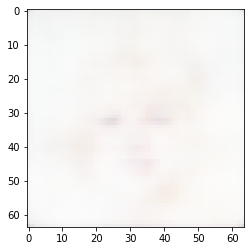

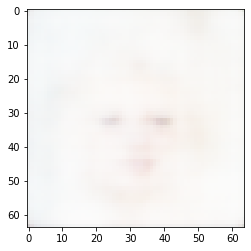

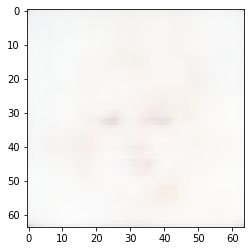

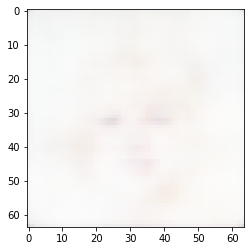

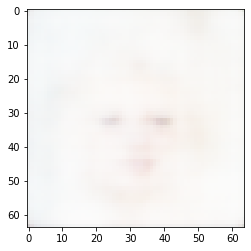

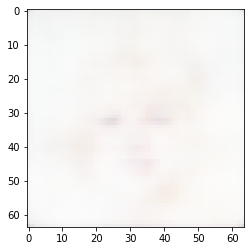

In [ ]:
# YOUR CODE GOES HERE
beta = 0.5
β=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
idx = 3
idx = torch.randint(len(β), size=(1,)).item()

# Get image and latent
def get_img_latent():
  # Sample random image
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img1, _ = training_data[sample_idx]
  print(f'img1.shape: {img1.shape}')

  img = img1.numpy().transpose((1, 2, 0))
  print(f'img.shape: {img.shape}')
  plt.figure(clear=True)
  plt.imshow(img)

  # add batch dimension
  imgs1 = torch.unsqueeze(img1, dim=0)
  imgs1[0]=1
  # Encode the image
  if torch.cuda.is_available():
    mu, logvar = model_2.encode(imgs1.cuda())
  else:
    mu, logvar = model_2.encode(imgs1)
  # reparametrize to get latent 
  latent_1 = model_2.reparametrize(mu, logvar)
  return img1, latent_1

img1, latent_1 = get_img_latent()
img2, latent_2 = get_img_latent()
print(f'img1.shape: {img1.shape}')
imgs = []
imgs.append(img1)
imgs.append(img2)

# extrapolate two latents
for beta in β:
  latent_11 = beta*latent_1 + (1-beta)*latent_2
  # Reconstruct image from latent
  x_rec1 = model_2.decode(latent_1)
  x_rec2 = model_2.decode(latent_2)
  x_rec = model_2.decode(latent_11)
  # show images
  img = x_rec1.cpu().detach().numpy()
  img = img[0].transpose((1, 2, 0))
  plt.figure()
  plt.imshow(img)
  img = x_rec2.cpu().detach().numpy()
  img = img[0].transpose((1, 2, 0))
  plt.figure()
  plt.imshow(img)

  img = x_rec.cpu().detach().numpy()
  img = img[0].transpose((1, 2, 0))
  plt.figure(clear=True)
  plt.imshow(img)


# Automatic PDF Generation and store in GDrive

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc > /dev/null 2>&1
!pip install pypandoc > /dev/null 2>&1

from google.colab import drive
drive.mount('/content/drive')
!cp 'drive/My Drive/Colab Notebooks/Assignment4_work.ipynb' ./

!jupyter nbconvert --to PDF "Assignment4_work.ipynb" > /dev/null 2>&1
!echo "pdf file generated"
#!ls -la
!cp './Assignment4_work.pdf' 'drive/My Drive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pdf file generated
